### Import libraries

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import warnings
import logging
import math
import visualkeras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from skimage.io import imread
from skimage.transform import resize

from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Dropout, Resize

from math import sqrt

tfk = tf.keras
tfkl = tfk.layers

print(tf.__version__)

2.9.2


In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Map activities to integers
label_mapping = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11
}
columns_y = ['Wish','Another','Comfortably','Money','Breathe','Time','Brain','Echoes','Wearing','Sorrow','Hey','Shine']
columns_x = ['Variable_1','Variable_2','Variable_3','Variable_4','Variable_5','Variable_6']

### Import dataset

In [8]:
data = np.load('training_dataset/x_train.npy')
labels = np.load('training_dataset/y_train.npy')
print(data.shape)
print(labels.shape)

(2429, 36, 6)
(2429,)


In [9]:
# Compute class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                 
                                    )
class_weights = dict(zip(np.unique(labels), class_weights))
class_weights

{0: 5.953431372549019,
 1: 1.6456639566395663,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.968954248366013}

In [10]:
test_set = False

if test_set:
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.20, shuffle = True)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.20, shuffle = True)
    print(X_valid.shape, X_test.shape, y_valid.shape, y_test.shape)
else:
    X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.10, shuffle = True)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2186, 36, 6) (243, 36, 6) (2186,) (243,)


### Training Variables

In [11]:
y_train = tfk.utils.to_categorical(y_train)
y_valid = tfk.utils.to_categorical(y_valid)
if test_set:
    y_test = tfk.utils.to_categorical(y_test)

input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

print(input_shape)
print(classes)

(36, 6)
12


# Data augmentation

In [12]:
def shift_sequence(data, num_features = 6):
    sample = np.copy(data)

    # Randomly select a time point from the sample
    time_index = np.random.randint(len(data))
    time_point = sample[time_index]

    # Shift the sample by the randomly selected time point
    shifted_sample = np.roll(sample, time_index, axis=0)

    # Replace a randomly selected feature with the randomly selected time point
    feature_index = np.random.randint(num_features)
    shifted_sample[0, feature_index:] = time_point[feature_index:]

    # Store the augmented sample in the augmented data array
    aug_data = np.copy(shifted_sample)
    return aug_data

In [13]:
my_augmenter = (
    AddNoise(scale=(0.01, 0.08)) @ 0.5  # with 50% probability, add random noise up to 1% - 8%
)

def apply_aug(elem):
    elem = shift_sequence(elem)
    elem = my_augmenter.augment(elem)
    return elem

(<Figure size 1600x200 with 1 Axes>, <AxesSubplot: >)

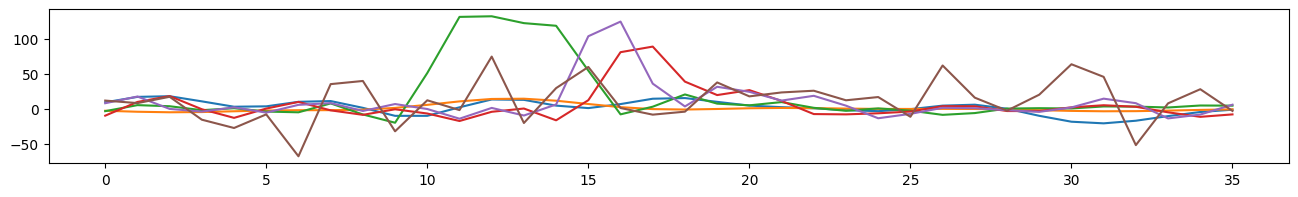

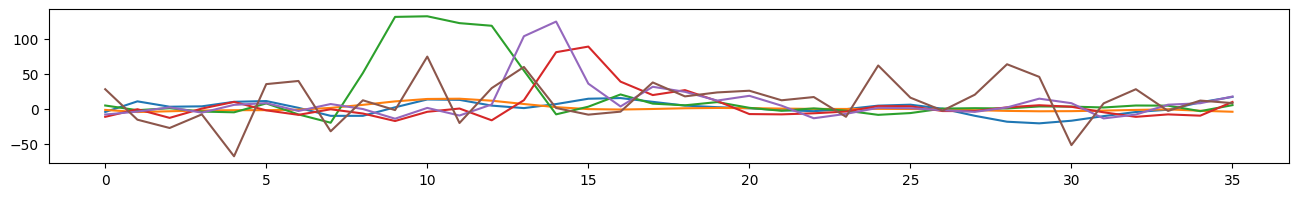

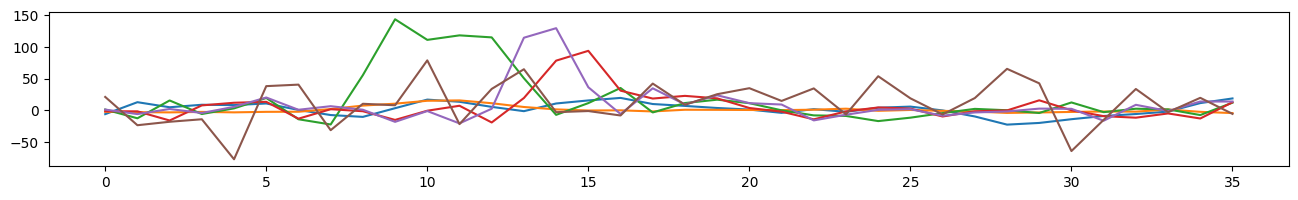

In [14]:
# Plot one original sequence
series = np.copy(X_train[2])
dummy_batch=np.expand_dims(series, axis=0)
plot(dummy_batch)

# Plot the same sequence shifted
series_shifted = np.copy(shift_sequence(X_train[2]))
dummy_batch_shifted=np.expand_dims(series_shifted, axis=0)
plot(dummy_batch_shifted)

# Plot the same sequence with noise injection
X_aug = my_augmenter.augment(dummy_batch_shifted)
plot(X_aug)

In [15]:
# AugSequencesGenerator is a keras Sequence class that automatically generate batches with defined length

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class AugSequencesGenerator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        # For each elem in the batch augmentation is applied
        return np.array([apply_aug(elem) for elem in batch_x]), np.array(batch_y)

# Instatiate a generator
generator = AugSequencesGenerator(x_set=X_train, y_set=y_train, batch_size=128)

# Model

In [16]:
def build_1DConv_ResNet(input_shape, classes):
    n_feature_maps = 64

    input_layer = tfkl.Input(input_shape)
    print(input_layer.shape)
    # BLOCK 1

    conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_1 = tfkl.add([shortcut_y, conv_z])
    dropout = tfkl.Dropout(.5, seed=seed)(output_block_1)
    output_block_1 = tfkl.Activation('relu')(dropout)

    # BLOCK 2
    print(output_block_1.shape)
    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_2 = tfkl.add([shortcut_y, conv_z])
    dropout = tfkl.Dropout(.5, seed=seed)(output_block_2)
    output_block_2 = tfkl.Activation('relu')(dropout)

    # BLOCK 3

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = tfkl.BatchNormalization()(output_block_2)

    output_block_3 = tfkl.add([shortcut_y, conv_z])
    dropout = tfkl.Dropout(.5, seed=seed)(output_block_3)
    output_block_3 = tfkl.Activation('relu')(dropout)

    # FINAL

    gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

    classifier = tfkl.Dense(128, activation='relu')(gap_layer)

    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    model = tfk.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [17]:
def build_BiLSTM_ResNet(input_shape, classes, n_hidden_states=64):
  lev1_units = 128
  lev2_units = 256

  # First, define the input layer
  input_layer = tfk.Input(shape=input_shape)

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # BLOCK 1

  bilstm = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(input_layer)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation('relu')(x)

  y = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(x)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.Activation('relu')(y)

  z = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(y)
  z = tfkl.BatchNormalization()(z)

  # expand channels for the sum
  shortcut_y = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(input_layer)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_1 = tfkl.add([shortcut_y, z])
  dropout = tfkl.Dropout(.5, seed=seed)(output_block_1)
  output_block_1 = tfkl.Activation('relu')(dropout)

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # BLOCK 2
  x = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(output_block_1)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation('relu')(x)

  y = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(x)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.Activation('relu')(y)

  z = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(y)
  z = tfkl.Bidirectional(tfkl.LSTM(lev2_units))(z)
  z = tfkl.BatchNormalization()(z)

  # expand channels for the sum
  shortcut_y = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(output_block_1)
  shortcut_y = tfkl.Bidirectional(tfkl.LSTM(lev2_units))(shortcut_y)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_2 = tfkl.add([shortcut_y, z])
  dropout = tfkl.Dropout(.5, seed=seed)(output_block_2)
  output_block_2 = tfkl.Activation('relu')(dropout)

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # Classifier
  classifier = tfkl.Dense(128, activation='relu')(output_block_2)
  output_layer = tfkl.Dense(classes, activation='softmax')(classifier)
  
  # Define the model
  model = tfk.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  return model

In [18]:
def build_BiLSTM_ResNet_with_attention(input_shape, classes):
  lev1_units = 128
  lev2_units = 256

  # First, define the input layer
  input_layer = tfk.Input(shape=input_shape)

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # BLOCK 1

  x = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(input_layer)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation('relu')(x)

  y = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(x)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.Activation('relu')(y)

  z = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(y)
  z = tfkl.BatchNormalization()(z)

  # expand channels for the sum
  shortcut_y = tfkl.Bidirectional(tfkl.LSTM(lev1_units, return_sequences=True))(input_layer)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_1 = tfkl.add([shortcut_y, z])
  dropout = tfkl.Dropout(.5, seed=seed)(output_block_1)
  output_block_1 = tfkl.Activation('relu')(dropout)

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # BLOCK 2
  x = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(output_block_1)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation('relu')(x)

  y = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(x)
  y = tfkl.BatchNormalization()(y)
  y = tfkl.Activation('relu')(y)

  z = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(y)
  z = tfkl.BatchNormalization()(z)

  # expand channels for the sum
  shortcut_y = tfkl.Bidirectional(tfkl.LSTM(lev2_units, return_sequences=True))(output_block_1)
  shortcut_y = tfkl.BatchNormalization()(shortcut_y)

  output_block_2 = tfkl.add([shortcut_y, z])
  dropout = tfkl.Dropout(.5, seed=seed)(output_block_2)
  output_block_2 = tfkl.Activation('relu')(dropout)

  units = lev2_units
  # Define the attention layer
  attention_layer = tf.keras.layers.Dense(1, activation='sigmoid')(output_block_2)
  attention_layer = tf.keras.layers.Flatten()(attention_layer)
  attention_layer = tf.keras.layers.Activation('softmax')(attention_layer)
  attention_layer = tf.keras.layers.RepeatVector(2 * units)(attention_layer)
  attention_layer = tf.keras.layers.Permute([2, 1])(attention_layer)

  # Apply the attention layer to the BiLSTM output
  weighted_output = tf.keras.layers.Multiply()([output_block_2, attention_layer])
  weighted_output = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(2 * units,))(weighted_output)

  # Concatenate the weighted output with the final hidden state of the BiLSTM
  concat_layer = tf.keras.layers.Concatenate()([weighted_output, output_block_2[:, -1, :]])

  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  #-----------------------------------------------------------------------------
  # Classifier
  classifier = tfkl.Dense(128, activation='relu')(concat_layer)
  classifier = tfkl.Dropout(.3, seed=seed)(classifier)
  output_layer = tfkl.Dense(classes, activation='softmax')(classifier)
  
  # Define the model
  model = tfk.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  return model

In [19]:
model = build_BiLSTM_ResNet_with_attention(input_shape, classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 36, 256)      138240      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 256)     1024        ['bidirectional[0][0]']          
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 36, 256)      0           ['batch_normalization[0][0]']

### Train

In [20]:
# Utility function to create folders and callbacks for training

def create_callbacks() :
    callbacks = []

    # Early Stopping -----------------------------------------------------
    es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)
    
    # Checkpointer
    checkpointer = ModelCheckpoint(filepath='./checkpoint/ResNet.h5', verbose=1, 
                                    save_best_only=True, monitor = "val_accuracy", mode = "auto",)
    callbacks.append(checkpointer)
    
    # Learning Rate Scheduler --------------------------------------------
    LRS_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    callbacks.append(LRS_callback)
    
    return callbacks

In [21]:
# Train the model
history = model.fit(
    x = generator,
    epochs = epochs,
    validation_data=(X_valid, y_valid),
    class_weight = class_weights,
    callbacks = create_callbacks()
).history

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 2.4575 - accuracy: 0.1798
Epoch 1: val_accuracy improved from -inf to 0.18519, saving model to ./checkpoint\ResNet.h5
18/18 [==============================] - 73s 1s/step - loss: 2.4575 - accuracy: 0.1798 - val_loss: 2.4244 - val_accuracy: 0.1852 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 1.7760 - accuracy: 0.2731
Epoch 2: val_accuracy improved from 0.18519 to 0.20988, saving model to ./checkpoint\ResNet.h5
18/18 [==============================] - 11s 604ms/step - loss: 1.7760 - accuracy: 0.2731 - val_loss: 2.3393 - val_accuracy: 0.2099 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 1.5694 - accuracy: 0.3532
Epoch 3: val_accuracy improved from 0.20988 to 0.21811, saving model to ./checkpoint\ResNet.h5
18/18 [==============================] - 11s 600ms/step - loss: 1.5694 - accuracy: 0.3532 - val_loss: 2.2291 - val_accuracy: 0.2181 - lr: 0.0010
E

### Plots

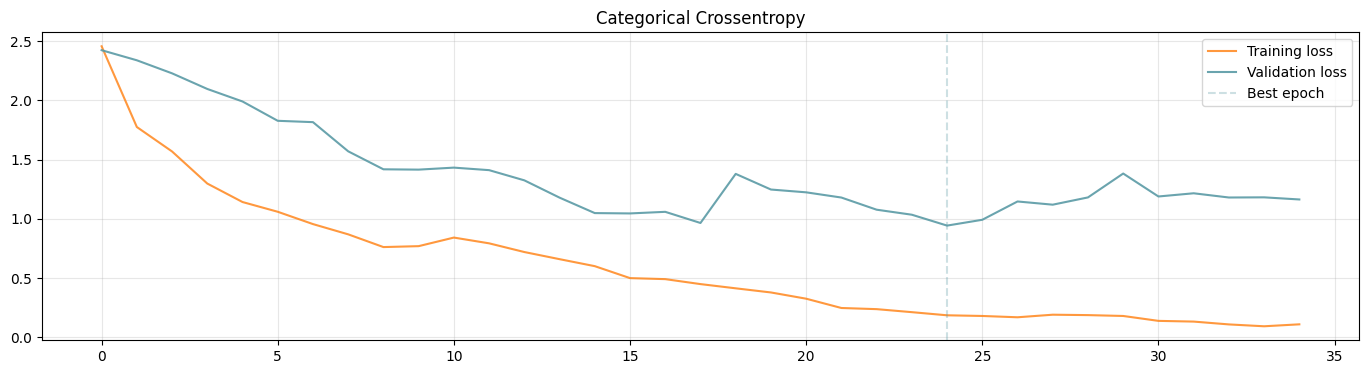

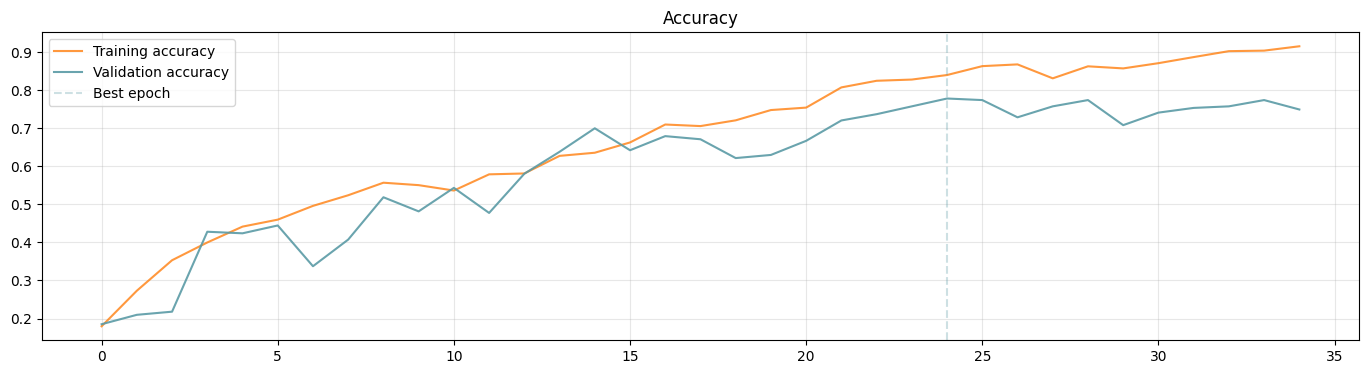

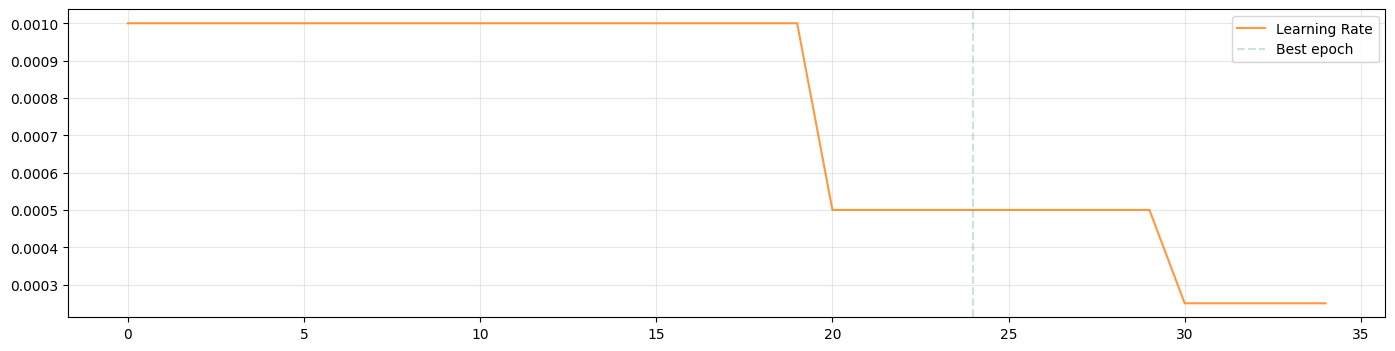

In [22]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [23]:
model = tfk.models.load_model('checkpoint/ResNet.h5', compile=False)

In [24]:
if(test_set):
    # Predict the test set with the BiLSTM
    predictions = model.predict(X_test)
    print(predictions.shape)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm.T, cmap='Reds' , xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    # plt.xlabel('True labels')
    # plt.ylabel('Predicted labels')
    plt.show()